In [11]:
import pandas as pd
mutations = pd.read_csv('../analysis/merged_variants_anno_vaf_filtered.txt', sep="\t",
                        header=0, index_col=0, low_memory=False)
metasamples = pd.read_excel('../Metadata3.xlsx')

In [12]:
# Keep only samples that are tumor-normal pair and labeled as included
df = metasamples.loc[(metasamples['INCLUDED'] == "Y")
                     & (metasamples['TUMOR_ONLY'] == "No")
                     & (metasamples['SAMPLE_TYPE'] != "gDNA")
                     & (metasamples['VAR2'].notnull()), 
                     ['PATIENT_ID', 'SAMPLE_ID']]
metasamples.index = metasamples['SAMPLE_ID']
meta_filtered = metasamples.reindex(df['SAMPLE_ID'].tolist())
SAMPLES = [x.strip() for x in df['SAMPLE_ID'] + '-' + df['PATIENT_ID']]
meta_filtered.index = SAMPLES
mutations_filtered = mutations.loc[:, mutations.columns[0:10].to_list() + SAMPLES]

In [13]:
print('Total patients {}'.format(len(set(meta_filtered['PATIENT_ID']))))
print('Total samples {}'.format(len(set(meta_filtered['SAMPLE_ID']))))

print('Total patients (E) {}'.format(len(set(meta_filtered[meta_filtered['VAR2'] == 'E']['PATIENT_ID']))))
print('Total samples (E) {}'.format(len(set(meta_filtered[meta_filtered['VAR2'] == 'E']['SAMPLE_ID']))))

print('Total patients (F) {}'.format(len(set(meta_filtered[meta_filtered['VAR2'] == 'F']['PATIENT_ID']))))
print('Total samples (F) {}'.format(len(set(meta_filtered[meta_filtered['VAR2'] == 'F']['SAMPLE_ID']))))

Total patients 18
Total samples 31
Total patients (E) 12
Total samples (E) 18
Total patients (F) 9
Total samples (F) 13


In [14]:
from collections import defaultdict

VAF_FILTER = 5.0
NUM_PATIENTS_FILTER = 1

mutations_seen_only_E = list()
mutations_seen_only_F = list()
mutations_seen_E = defaultdict(list)
mutations_seen_F = defaultdict(list)

SAMPLES_E = meta_filtered[meta_filtered['VAR2'] == 'E'].index.to_list()
SAMPLES_F = meta_filtered[meta_filtered['VAR2'] == 'F'].index.to_list()

for index, row in mutations_filtered.iterrows():
    samples_E = list()
    samples_F = list()
    gene = row['GENE']
    acc_vaf_E = 0
    acc_vaf_F = 0
    
    for column, value in row[10:].items():
        if float(value) >= VAF_FILTER:
            if column in SAMPLES_E:
                acc_vaf_E += float(value)
                samples_E.append(column)
            if column in SAMPLES_F:
                acc_vaf_F += float(value)
                samples_F.append(column)
                
    if len(samples_E) > 0:
        patients = set([x.split('-')[-1] for x in samples_E])
        for g in gene.split('|'):
            mutations_seen_E[g].append((index, acc_vaf_E, samples_E, patients))
        
    if len(samples_F) > 0:
        patients = set([x.split('-')[-1] for x in samples_F])
        for g in gene.split('|'):
            mutations_seen_F[g].append((index, acc_vaf_F, samples_F, patients))
        
    if len(samples_E) > 0 and len(samples_F) == 0:
        patients = set([x.split('-')[-1] for x in samples_E])
        if len(patients) >= NUM_PATIENTS_FILTER:
            mutations_seen_only_E.append((index, gene, samples_E, len(samples_E), len(patients)))
            
    if len(samples_E) == 0 and len(samples_F) > 0:
        patients = set([x.split('-')[-1] for x in samples_F])
        if len(patients) >= NUM_PATIENTS_FILTER:
            mutations_seen_only_F.append((index, gene, samples_F, len(samples_F), len(patients)))

In [15]:
import numpy as np

with open('../analysis/analysis_responders/E/genes_table.txt', 'w') as f:
    f.write('GENE\tCUM_VAF\tNUM_MUTATIONS\tMUTATIONS\tNUM_SAMPLES\tSAMPLES\tNUM_PATIENTS\tPATIENTS\n')
    for gene, records in mutations_seen_E.items():
        acc_vaf = 0
        patients = set()
        samples = set()
        mutations = set()
        for mut in records:
            acc_vaf += mut[1]
            mutations.add(mut[0])
            samples.update(mut[2])
            patients.update(mut[3])
        f.write('\t'.join([gene,
                           str(np.round(acc_vaf, 2)),
                           str(len(mutations)), 
                           ';'.join(mutations), 
                           str(len(samples)), 
                           ';'.join(samples),
                           str(len(patients)),
                           ';'.join(patients)]) + '\n')

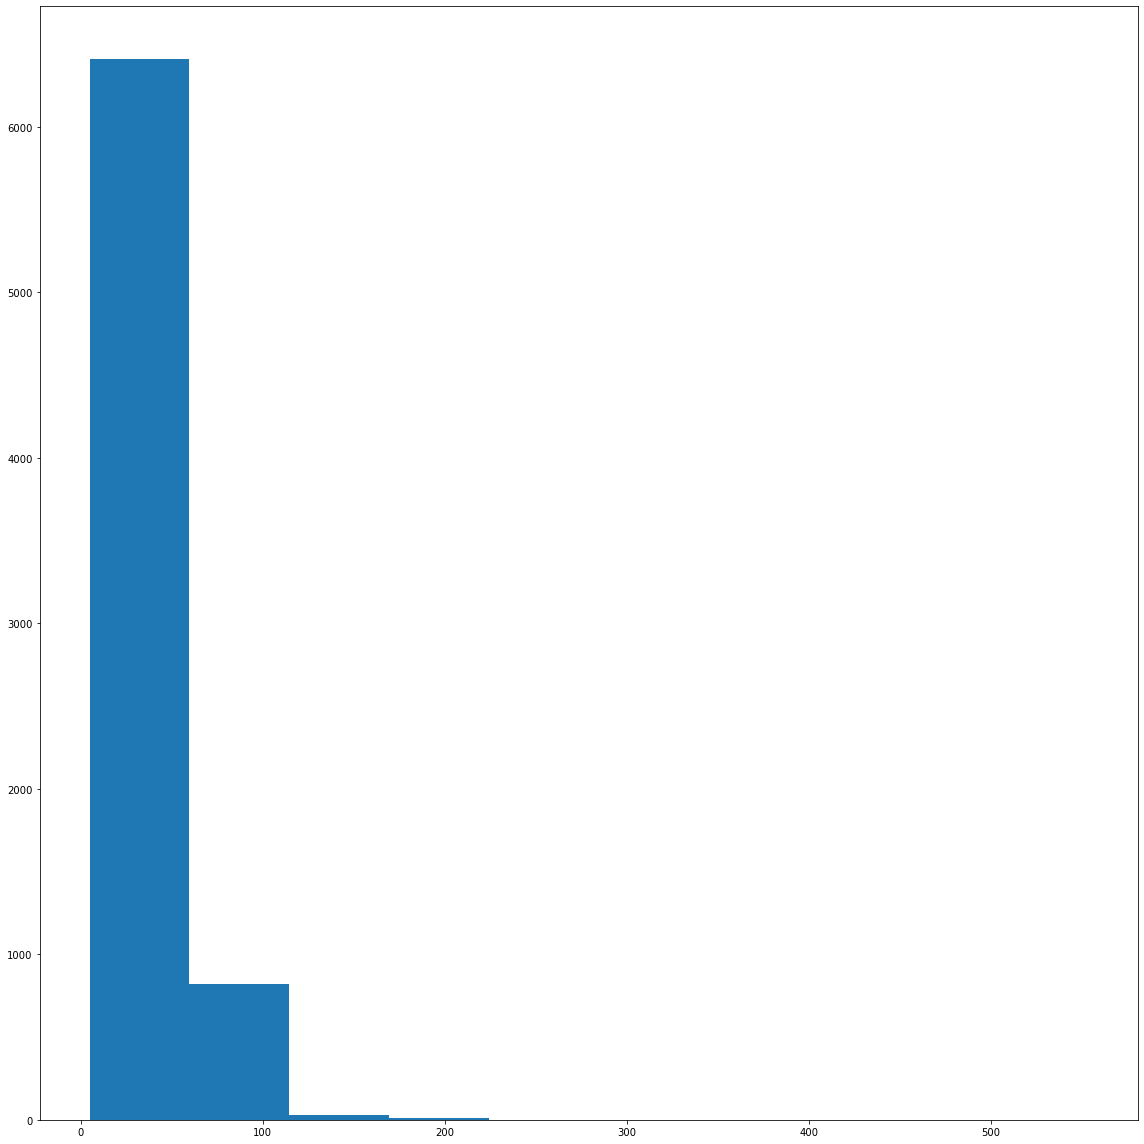

In [16]:
from collections import Counter
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

records = [y for x in mutations_seen_E.values() for y in x]
cum_vaf_values = [x[1] for x in records]
mutations_per_patient = Counter([y for x in records for y in x[3]])
mutations_per_sample = Counter([y.split('-')[0] for x in records for y in x[2]])

fig, ax = plt.subplots(figsize=(16,16))
ax.hist(cum_vaf_values, bins=10, density=False)
fig.tight_layout()
fig.savefig('../analysis/analysis_responders/E/cum_vaf_dist.png')

In [17]:
with open('../analysis/analysis_responders/F/genes_table.txt', 'w') as f:
    f.write('GENE\tCUM_VAF\tNUM_MUTATIONS\tMUTATIONS\tNUM_SAMPLES\tSAMPLES\tNUM_PATIENTS\tPATIENTS\n')
    for gene, records in mutations_seen_F.items():
        acc_vaf = 0
        patients = set()
        samples = set()
        mutations = set()
        for mut in records:
            acc_vaf += mut[1]
            mutations.add(mut[0])
            samples.update(mut[2])
            patients.update(mut[3])
        f.write('\t'.join([gene,
                           str(np.round(acc_vaf, 2)),
                           str(len(mutations)), 
                           ';'.join(mutations), 
                           str(len(samples)), 
                           ';'.join(samples),
                           str(len(patients)),
                           ';'.join(patients)]) + '\n')

In [18]:
import gseapy as gp
import matplotlib.pyplot as plt

#genes_E = [x[1] for x in mutations_seen_E]
#enr = gp.enrichr(gene_list = genes_E,
#                 gene_sets = ['KEGG_2019_Human','GO_Biological_Process_2018', 'GO_Molecular_Function_2018'],
#                 organism = 'Human',
#                 description = 'Group E',
#                 outdir = '../analysis/analysis_responders/E',
#                 # no_plot=True,
#                 cutoff = 1.0)

mutations_E = mutations_filtered.loc[[x[0] for x in mutations_seen_only_E], :]
mutations_E.insert(10, 'SAMPLES', [';'.join(x[2]) for x in mutations_seen_only_E])
mutations_E.insert(11, 'NUM_SAMPLES', [x[3] for x in mutations_seen_only_E])
mutations_E.insert(12, 'NUM_PATIENTS', [x[4] for x in mutations_seen_only_E])
mutations_E.to_csv('../analysis/analysis_responders/E/mutations_table.txt', sep="\t", header=True)

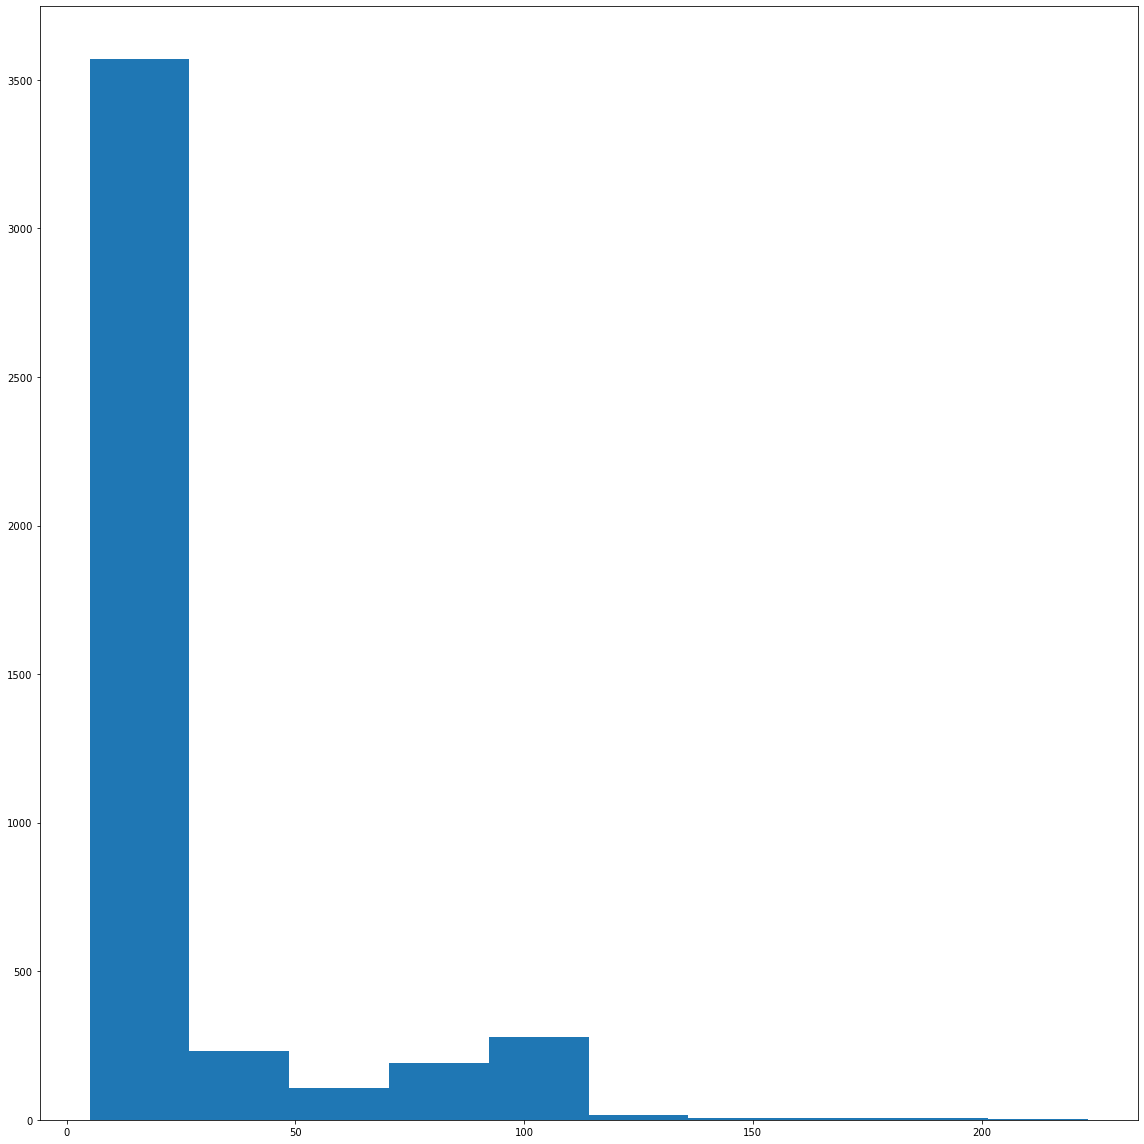

In [19]:
from collections import Counter
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

records = [y for x in mutations_seen_F.values() for y in x]
cum_vaf_values = [x[1] for x in records]
mutations_per_patient = Counter([y for x in records for y in x[3]])
mutations_per_sample = Counter([y.split('-')[0] for x in records for y in x[2]])

fig, ax = plt.subplots(figsize=(16,16))
ax.hist(cum_vaf_values, bins=10, density=False)
fig.tight_layout()
fig.savefig('../analysis/analysis_responders/F/cum_vaf_dist.png')

In [20]:
import gseapy as gp
import matplotlib.pyplot as plt

#genes_F = [x[1] for x in mutations_seen_F]
#enr = gp.enrichr(gene_list = genes_F,
#                 gene_sets = ['KEGG_2019_Human','GO_Biological_Process_2018', 'GO_Molecular_Function_2018'],
#                 organism = 'Human',
#                 description = 'Group F',
#                 outdir = '../analysis/analysis_responders/F',
#                 # no_plot=True,
#                 cutoff = 1.0)

mutations_F = mutations_filtered.loc[[x[0] for x in mutations_seen_only_F], :]
mutations_F.insert(10, 'SAMPLES', [';'.join(x[2]) for x in mutations_seen_only_F])
mutations_F.insert(11, 'NUM_SAMPLES', [x[3] for x in mutations_seen_only_F])
mutations_F.insert(12, 'NUM_PATIENTS', [x[4] for x in mutations_seen_only_F])
mutations_F.to_csv('../analysis/analysis_responders/F/mutations_table.txt', sep="\t", header=True)